In [1]:
import os
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from astropy.constants import k_B, h, c, m_p, m_e, eps0, e
k_B = k_B.to(u.erg / u.K)
h = h.to(u.erg * u.s)
c = c.to(u.cm / u.s)
m_p = m_p.to(u.g)
m_e = m_e.to(u.g)
R = 1.0968e5 * u.cm**(-1)

In [2]:
dir = '/home/pablo/Desktop/master/atmosferas_estelares/opacidades/data/'
files = ['t5000.dat', 't8000.dat']

data_dic = {file.split('.')[0]: file for file in files}
for file in files:
    file_name = file.split('.')[0]
    data_dic[file_name] = {}

    path = dir + file
    with open(path, 'r') as file:
        lines = file.readlines()

    d1 = lines[:11]
    d2 = lines[11:23]

    d1 = ''.join(d1)
    d2 = ''.join(d2)

    data_dic[file_name]['d1'] = d1
    data_dic[file_name]['d2'] = d2

    d3 = lines[24:]
    d3 = ''.join(d3)
    data_io = StringIO(d3)
    df = pd.read_csv(data_io, delim_whitespace=True)
    df = df.iloc[:, 1:]

    data_dic[file_name]['data'] = df


atomic_data = {'HI': {}, 'HII': {}, 'H-': {}}
Us = [2, 1, 1]
gs = [[2, 8, 18], [], []]

wave_numbers_HI = [0,
                   82259.158 ,
                   97492.304 ,]
wave_number = [wave_numbers_HI, 
               [], 
               [],
               [],[],[]]

ion_en = [13.59844 * u.eV, 0 * u.eV, 0.755 * u.eV]

for i, el in enumerate(atomic_data.keys()):
    atomic_data[el]['U'] = Us[i]
    atomic_data[el]['g'] = gs[i]
    atomic_data[el]['wave_number'] = wave_number[i]
    atomic_data[el]['ex_en'] = [(h*c * wave_number[i][k]*u.cm**(-1)).to(u.eV) for k in range(len(wave_number[i]))]
    atomic_data[el]['ion_en'] = ion_en[i]



$$\textbf{Functions}$$

In [3]:
# Saha
def saha(N_e, T, U_p, U_m, chi_lu):
    fact1 = 2 * U_p / (N_e * U_m)
    fact2 = (2 * np.pi * m_e * k_B / (h**2))**(3/2)
    fact2 = fact2.to(u.K**(-3/2) * u.cm**(-3))
    exp = np.exp(-(chi_lu / (k_B * T)))
    exp = exp.to(u.dimensionless_unscaled)
    result = fact1 * fact2 * T**(3/2) * exp
    return result.to(u.dimensionless_unscaled)

def saha_matrix(a,b):
    arr = [[a, -1, 0],
           [-1, 0, b],
           [0, 1, -1]]
    return np.array(arr)

# Boltzmann

def boltzmann(gl, gu, chi_l, chi_u, T):
    exp = np.exp(-(chi_u-chi_l)/(k_B*T))
    exp = exp.to(u.dimensionless_unscaled)
    result = gu/gl * exp
    return result.to(u.dimensionless_unscaled)

def boltzmann_matrix(a,b):
    arr = [[1, 1, 1],
           [a, -1, 0],
           [0, b, -1]]
    return np.array(arr)

In [4]:
stars = ['t5000', 't8000']
results = {star: {} for star in stars}


for key, temp in enumerate(stars): 
    data = data_dic[temp]['data']
    sols_saha = np.zeros((len(data_dic['t5000']['data']), 3))
    sols_boltzman = np.zeros((len(data_dic['t5000']['data']), 3))

    for i in range(len(data_dic['t5000']['data'])):
        P_e = np.array(data['Pe'])[i] * u.erg / u.cm**3
        T = np.array(data['T'])[i] * u.K

        N_e = P_e / (k_B * T) 
        a = saha(N_e, T, atomic_data['HII']['U'], atomic_data['HI']['U'], atomic_data['HI']['ion_en'])
        b = saha(N_e, T, atomic_data['HI']['U'],  atomic_data['H-']['U'], atomic_data['H-']['ion_en'])
        matrix_saha = saha_matrix(a, b)
        sols_saha[i, :] = np.linalg.solve(matrix_saha, np.array([0,0,N_e.value]))

        alpha = boltzmann(atomic_data['HI']['g'][0],     atomic_data['HI']['g'][1],
                          atomic_data['HI']['ex_en'][0], atomic_data['HI']['ex_en'][1], T)
        beta = boltzmann( atomic_data['HI']['g'][1],     atomic_data['HI']['g'][2],
                          atomic_data['HI']['ex_en'][1], atomic_data['HI']['ex_en'][2], T)
        
        matrix_boltzman = boltzmann_matrix(alpha, beta)
        sols_boltzman[i, :] = np.linalg.solve(matrix_boltzman, np.array([np.linalg.solve(matrix_saha, np.array([0,0,N_e.value]))[0],0,0]))

    P_e = np.array(data['Pe'])
    T = np.array(data['T'])
    N_e = P_e / (k_B.value * T) 
    results[temp]['Ne'] = np.array(N_e)
    results[temp]['NHI'] = np.array(sols_saha[:, 0])
    results[temp]['NHII'] = np.array(sols_saha[:, 1])
    results[temp]['NH-'] = np.array(sols_saha[:, 2])
    results[temp]['NHI1'] = np.array(sols_boltzman[:, 0])
    results[temp]['NHI2'] = np.array(sols_boltzman[:, 1])
    results[temp]['NHI3'] = np.array(sols_boltzman[:, 2])

In [5]:
lgTauR = data['lgTauR']
tauR = 10**lgTauR

for star in stars:
    print('\midrule')
    for tau in [0.5, 5.]:
        near_value = np.argmin(np.abs(tauR - tau))
        print(f"{tauR[near_value]:.2f} & "
              f"{results[star]['NH-'][near_value]:.2e} & "
              f"{results[star]['NHI'][near_value]:.2e} & "
              f"{results[star]['NHII'][near_value]:.2e} & "
              f"{results[star]['Ne'][near_value]:.2e} & "
              f"{results[star]['NHI1'][near_value]:.2e} & "
              f"{results[star]['NHI2'][near_value]:.2e} & "
              f"{results[star]['NHI3'][near_value]:.2e} \\\\")

\midrule
0.50 & 1.35e+11 & 7.30e+18 & 1.10e+13 & 1.09e+13 & 7.30e+18 & 1.52e+09 & 4.25e+07 \\
5.01 & 5.14e+10 & 2.73e+17 & 3.23e+14 & 3.23e+14 & 2.73e+17 & 7.12e+10 & 7.48e+09 \\
\midrule
0.50 & 1.61e+09 & 1.58e+16 & 2.26e+14 & 2.26e+14 & 1.58e+16 & 1.83e+10 & 2.54e+09 \\
5.01 & 5.83e+09 & 8.37e+15 & 3.42e+15 & 3.41e+15 & 8.37e+15 & 6.37e+11 & 1.91e+11 \\


$$\textbf{Plot}$$

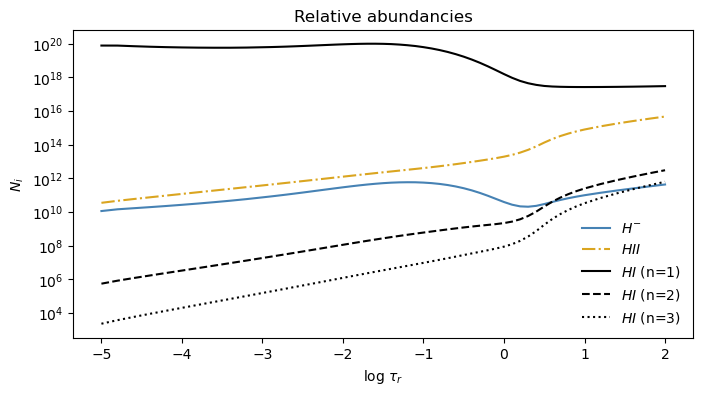

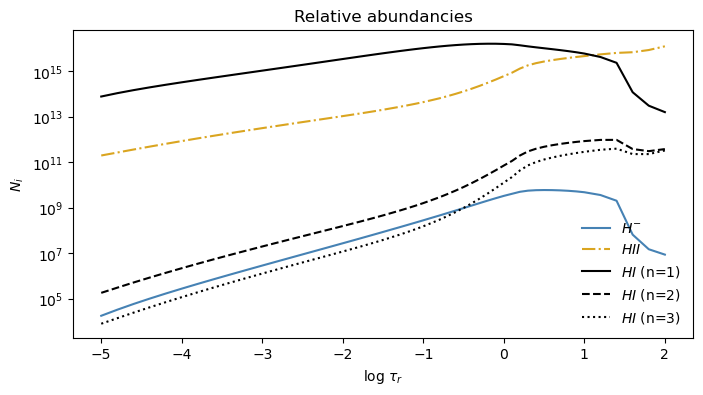

In [13]:
temperatures = [5000, 8000]

for ii, star in enumerate(stars):

    fig_abundance = plt.figure(figsize=(8,4))

    plt.plot(lgTauR, results[star]['NH-'], ls = '-', color = 'steelblue', label=r'$H^{-}$')
    # plt.plot(lgTauR, results[star]['NHI'], ls = '-', color = 'steelblue', label=r'$HI$')
    plt.plot(lgTauR, results[star]['NHII'], ls = '-.', color = 'goldenrod', label=r'$HII$')
    plt.plot(lgTauR, results[star]['NHI1'], ls = '-', color = 'k', label=r'$HI$ (n=1)')
    plt.plot(lgTauR, results[star]['NHI2'], ls = '--', color = 'k', label=r'$HI$ (n=2)')
    plt.plot(lgTauR, results[star]['NHI3'], ls = ':', color = 'k', label=r'$HI$ (n=3)')

    plt.title('Relative abundancies')
    plt.xlabel(r'log $\tau_r$')
    plt.ylabel(r'$N_i$')
    plt.yscale('log')
    plt.legend(frameon=False)
    plt.show()

    fig_abundance.savefig(f'../figures/abundance_{star}.pdf')

$$\textbf{Opacities}$$

In [7]:
# Electron scattering 

def kappa_es(N_e):
    fact1 = 8 * np.pi / 3
    fact2 = (e.esu.value)**2 / (m_e.value * c.value**2)
    result = fact1 * fact2**2 * N_e
    return result 

# Free-Free for H

def HI_kappa_ff(lamb, T, NHII, Ne):
    cte1 = 3.7e8
    Z = 1
    nu = c.value / lamb
    fact1 = cte1 * Z**2 
    fact2 = T**(1/2) * nu**3
    f1 = 0.3456
    f2 = lamb * k_B.value * T / (h.value * c.value)
    f3 = 1/2
    f4 = (lamb*R.value)**(-1/3)
    gaunt =1 + f1*f4*(f2+f3)
    result = NHII * Ne *  gaunt * fact1 / fact2
    return result


# Free-Free for H-

f0cs = [-2.2763, -1.6850, 0.76661, -0.053346]
f1cs = [15.2827, -9.2846, 1.99381, -0.142632]
f2cs = [-197.789, 190.266, -67.9775, 10.6913, -0.625151]
fcs = [f0cs, f1cs, f2cs]

def Hm_kappa_ff(lamb, T, Pe, NHI):
    lamb = lamb * 10**8
    fs = [np.polyval(fc[::-1], np.log10(lamb)) for fc in fcs]
    theta = 5040 / T
    exponent = -26 + np.polyval(fs[::-1], np.log10(theta))
    result = Pe * 10**exponent * NHI
    return result

# Bound Free for H

def HI_kappa_bf(lamb, NHI, n=1):
    lamb_0 = (R.value/n**2)**(-1)
    nu = c.value/lamb
    cte1 = 2.815e29 
    cte2 = 0.3456
    Z=1
    g_bf = 1 - cte2 * (lamb*R.value)**(-1/3) * (lamb*R.value / (n**2) - 1/2)
    sigma_bf = cte1 * Z**4 * g_bf / (n**5 * nu**3)
    sigma_bf = np.where(lamb > lamb_0, 0, sigma_bf)
    result = NHI * sigma_bf
    return result

# Bound-Free for H-

a_coefs = [1.99654,
           -1.18267e-5,
           2.64243e-6,
           -4.40524e-10,
           3.23992e-14,
           -1.39568e-18,
           2.78701e-23]

def Hm_kappa_bf(lamb, NHm):
    lamb = lamb * 10**8
    result =  NHm * np.polyval(a_coefs[::-1], lamb) * 10**-18
    return result


In [41]:
lamb = np.array([n**2 / R.value  for n in [1,2,3]])
lambdas = np.array([lamb[0]-1e-8, lamb[0]+1e-8, 
                    lamb[1]-1e-8, lamb[1]+1e-8, 
                    lamb[2]-1e-8, lamb[2]+1e-8])

near_value = np.argmin(np.abs(tauR - 1.))

lines = ['L_alpha', 'L_beta', 'H_alpha']
gs = [2, 8, 18]
wavelengths = [1215.67, 1025.72, 6562.74]
fs = [0.4162, 0.07910, 0.6407]
As = [4.699e8, 5.575e7, 4.410e7]

line_dic = {}
for ii, line in enumerate(lines):
    line_dic[line] = {'wavelength': wavelengths[ii], 'f': fs[ii]}
    line_dic[line]['A'] = As[ii]
    line_dic[line]['sigma'] = np.pi * fs[ii] * 4.8032e-10**2 / (m_p.value * c.value) 

line_dic['L_alpha']['damp'] = 4*np.pi * As[0]
line_dic['L_beta']['damp'] = 4*np.pi * (As[1] + As[0])
line_dic['H_alpha']['damp'] = 4*np.pi * (As[2])

kappas = {star: {} for star in stars}

for star in stars:
    vals = results[star]
    data = data_dic[star]['data']

    Pe = data['Pe'][near_value]
    T = data['T'][near_value]
    Ne =  vals['Ne'][near_value]
    NHm = vals['NH-'][near_value]
    NHI = vals['NHI'][near_value]
    NHII = vals['NHII'][near_value]
    NHI1 = vals['NHI1'][near_value]
    NHI2 = vals['NHI2'][near_value]
    NHI3 = vals['NHI3'][near_value]
    NHIs = [NHI1, NHI2, NHI3]
    

    kappas[star]['es'] = np.array([kappa_es(Ne)]*len(lambdas))

    kappas[star]['ff_Hm']= Hm_kappa_ff(lambdas, T, Pe,  Ne)
    kappas[star]['ff_HI']= HI_kappa_ff(lambdas, T, NHI, Ne)

    kappas[star]['bf_Hm'] = Hm_kappa_bf(lambdas, NHm)
    kappas[star]['bf_HI1'] = HI_kappa_bf(lambdas, NHI1, n=1)
    kappas[star]['bf_HI2'] = HI_kappa_bf(lambdas, NHI2, n=2)
    kappas[star]['bf_HI3'] = HI_kappa_bf(lambdas, NHI3, n=3)
    kappas[star]['bf_HI'] = kappas[star]['bf_HI1'] + kappas[star]['bf_HI2'] + kappas[star]['bf_HI3']

    kappas[star]['kappa_L_alpha'] = line_dic['L_alpha']['sigma'] * (NHIs[1-1] - (gs[1-1]/gs[2-1])*NHIs[2-1])
    kappas[star]['kappa_L_beta'] = line_dic['L_beta']['sigma'] * (NHIs[1-1] - (gs[1-1]/gs[3-1])*NHIs[3-1])
    kappas[star]['kappa_H_alpha'] = line_dic['H_alpha']['sigma'] * (NHIs[2-1] - (gs[2-1]/gs[3-1])*NHIs[3-1])


In [9]:
names = [r'$\boldsymbol{Process}$', 
         r'$\boldsymbol{\kappa_e}$', 
         r'$\boldsymbol{\kappa_{f-f, H^{-}}}$', 
         r'$\boldsymbol{\kappa_{f-f, HI}}$', 
         r'$\boldsymbol{\kappa_{b-f, H^{-}}}$',
         r'$\boldsymbol{\kappa_{b-f, HI}}$ (n=1)',
         r'$\boldsymbol{\kappa_{b-f, HI}}$ (n=2)',
         r'$\boldsymbol{\kappa_{b-f, HI}}$ (n=3)']

sign = ['-', '+', '-', '+', '-', '+']

def scientific_notation_tex(value):
    """Convert a number to scientific notation in LaTeX format with $ for math mode."""
    mantissa, exponent = f"{value:.2e}".split('e')
    return rf"${mantissa} \cdot 10^{{{int(exponent)}}}$"

for ii, star in enumerate(stars):
    print('\\hline \\midrule')              
    print('& & & & \\textbf{T =', temperatures[ii], 'K} & & & \\\\')
    print('\\hline \\midrule')
    print(" & ".join(names) + "\\vspace{0.2cm} \\\\")
    for jj, lamb in enumerate(lambdas):
        print(f"${lamb*1e9:.0f}$ {sign[jj]} $\Delta \lambda$ [$\AA$] & "
              f"{scientific_notation_tex(kappas[star]['es'][jj])} & "
              f"{scientific_notation_tex(kappas[star]['ff_Hm'][jj])} & "
              f"{scientific_notation_tex(kappas[star]['ff_HI'][jj])} & "
              f"{scientific_notation_tex(kappas[star]['bf_Hm'][jj])} & "
              f"{scientific_notation_tex(kappas[star]['bf_HI1'][jj])} & "
              f"{scientific_notation_tex(kappas[star]['bf_HI2'][jj])} & "
              f"{scientific_notation_tex(kappas[star]['bf_HI3'][jj])} \\\\")


\hline \midrule
& & & & \textbf{T = 5000 K} & & & \\
\hline \midrule
$\boldsymbol{Process}$ & $\boldsymbol{\kappa_e}$ & $\boldsymbol{\kappa_{f-f, H^{-}}}$ & $\boldsymbol{\kappa_{f-f, HI}}$ & $\boldsymbol{\kappa_{b-f, H^{-}}}$ & $\boldsymbol{\kappa_{b-f, HI}}$ (n=1) & $\boldsymbol{\kappa_{b-f, HI}}$ (n=2) & $\boldsymbol{\kappa_{b-f, HI}}$ (n=3)\vspace{0.2cm} \\
$9107$ - $\Delta \lambda$ [$\AA$] & $1.28 \cdot 10^{-11}$ & $2.87 \cdot 10^{-14}$ & $4.97 \cdot 10^{-9}$ & $1.49 \cdot 10^{-7}$ & $1.01 \cdot 10^{1}$ & $5.81 \cdot 10^{-10}$ & $3.19 \cdot 10^{-12}$ \\
$9127$ + $\Delta \lambda$ [$\AA$] & $1.28 \cdot 10^{-11}$ & $2.88 \cdot 10^{-14}$ & $5.00 \cdot 10^{-9}$ & $1.50 \cdot 10^{-7}$ & $0.00 \cdot 10^{0}$ & $5.85 \cdot 10^{-10}$ & $3.21 \cdot 10^{-12}$ \\
$36460$ - $\Delta \lambda$ [$\AA$] & $1.28 \cdot 10^{-11}$ & $2.78 \cdot 10^{-13}$ & $3.07 \cdot 10^{-7}$ & $7.97 \cdot 10^{-7}$ & $0.00 \cdot 10^{0}$ & $3.06 \cdot 10^{-8}$ & $1.82 \cdot 10^{-10}$ \\
$36480$ + $\Delta \lambda$ [$\AA$]

In [ ]:
names = [r'$\boldsymbol{\kappa_{b-b}}$', 
         r'$\boldsymbol{L_{\alpha}}$', 
         r'$\boldsymbol{L_{\beta}}$', 
         r'$\boldsymbol{H_{\alpha}}$']


print("\\hline \\midrule")
print(" & ".join(names) + "\\vspace{0.2cm} \\\\")

for ii, star in enumerate(stars):
    row = [f"{temperatures[ii]} K"]
    for line in lines:
        row.append(f"{scientific_notation_tex(kappas[star]['kappa_' + line])}")  
    print(" & ".join(row) + " \\\\")    

\hline \midrule
$\boldsymbol{\kappa_{b-b}}$ & $\boldsymbol{L_{\alpha}}$ & $\boldsymbol{L_{\beta}}$ & $\boldsymbol{H_{\alpha}}$\vspace{0.2cm} \\
5000 K & $9.35 \cdot 10^{12}$ & $1.78 \cdot 10^{12}$ & $1.97 \cdot 10^{4}$ \\
8000 K & $9.39 \cdot 10^{10}$ & $1.78 \cdot 10^{10}$ & $6.11 \cdot 10^{5}$ \\


In [133]:
lambdas = np.linspace(500, 20000, 1000)*u.AA.to(u.cm)

for star in stars:

    vals = results[star]
    data = data_dic[star]['data']

    Pe = np.zeros_like(lambdas) + data['Pe'][near_value]
    T = np.zeros_like(lambdas) + data['T'][near_value]
    Ne =  np.zeros_like(lambdas) + vals['Ne'][near_value]
    NHm = np.zeros_like(lambdas) + vals['NH-'][near_value]
    NHI = np.zeros_like(lambdas) + vals['NHI'][near_value]
    NHII = np.zeros_like(lambdas) + vals['NHII'][near_value]
    NHI1 = np.zeros_like(lambdas) + vals['NHI1'][near_value]
    NHI2 = np.zeros_like(lambdas) + vals['NHI2'][near_value]
    NHI3 = np.zeros_like(lambdas) + vals['NHI3'][near_value]
    
    kappas[star]['plt_es'] = kappa_es(Ne)

    kappas[star]['plt_ff_Hm']= Hm_kappa_ff(lambdas, T, Pe,  Ne)
    kappas[star]['plt_ff_HI']= HI_kappa_ff(lambdas, T, NHI, Ne)

    kappas[star]['plt_bf_Hm'] = Hm_kappa_bf(lambdas, NHm)
    kappas[star]['plt_bf_HI1'] = HI_kappa_bf(lambdas, NHI1, n=1)
    kappas[star]['plt_bf_HI2'] = HI_kappa_bf(lambdas, NHI2, n=2)
    kappas[star]['plt_bf_HI3'] = HI_kappa_bf(lambdas, NHI3, n=3)
    kappas[star]['plt_bf_HI'] = kappas[star]['plt_bf_HI1'] + kappas[star]['plt_bf_HI2'] + kappas[star]['plt_bf_HI3']


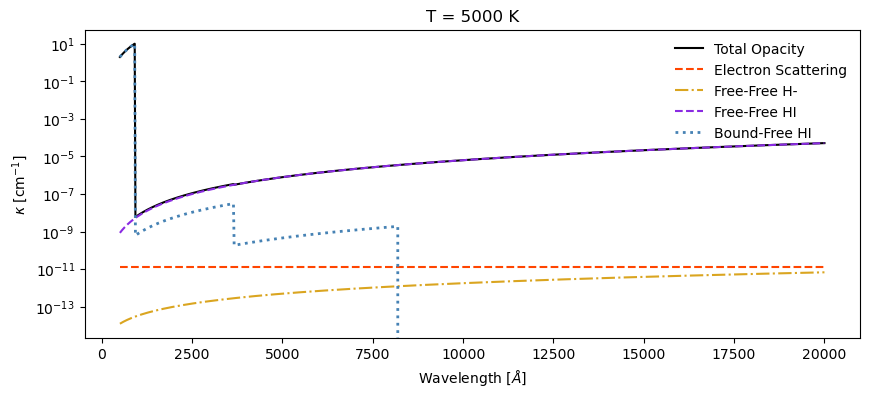

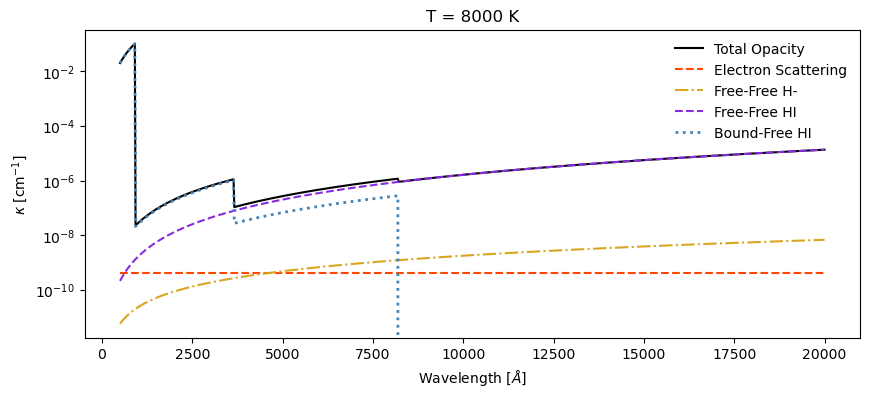

In [138]:
lam = lambdas * u.cm.to(u.AA)

for ii, star in enumerate(stars):
    total_kappa = (
        kappas[star]['plt_es'] +
        kappas[star]['plt_ff_Hm'] +
        kappas[star]['plt_ff_HI'] +
        kappas[star]['plt_bf_HI'])



    fig_opacities = plt.figure(figsize=(10,4))

    plt.plot(lam, total_kappa, color='k', ls='-', lw=1.5, label='Total Opacity')
    plt.plot(lam, kappas[star]['plt_es'], ls='--', lw=1.5, label='Electron Scattering', color='orangered')
    plt.plot(lam, kappas[star]['plt_ff_Hm'], ls='-.', lw=1.5, label='Free-Free H-', color='goldenrod')
    plt.plot(lam, kappas[star]['plt_ff_HI'], ls='--', lw=1.5, label='Free-Free HI', color='blueviolet')
    plt.plot(lam, kappas[star]['plt_bf_HI'], ls=':', lw=2, label='Bound-Free HI', color='steelblue')


    plt.xlabel(r'Wavelength [$\AA$]')
    plt.ylabel(r'$\kappa$ [cm$^{-1}$]')
    plt.title(f'T = {temperatures[ii]} K')
    plt.legend(frameon=False, loc='upper right')
    plt.yscale('log')
    plt.show()
    fig_opacities.savefig(f'../figures/opacities_{star}.pdf')